In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sys 
import os

# this line walks up file directory so rule-vetting is cwd
# Currently this breaks if chunk is run multiple times
os.chdir(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))))
print(os.getcwd())

/Users/ishaansrivastava/Documents/Stat215A/csi-pecarn-rule-vetting


In [2]:
import rulevetting.api.viz as viz
from rulevetting.projects.csi_pecarn.dataset import Dataset

In [3]:
avdf_all = Dataset().get_data()
avdf_ran = Dataset().get_data(control_types=['ran'])
avdf_moi = Dataset().get_data(control_types=['moi'])
avdf_ems = Dataset().get_data(control_types=['ems'])

read all the csvs...
 ['analysisvariables.csv', 'clinicalpresentationfield.csv', 'clinicalpresentationoutside.csv', 'clinicalpresentationsite.csv', 'demographics.csv', 'injuryclassification.csv', 'injurymechanism.csv', 'kappa.csv', 'medicalhistory.csv', 'radiologyoutside.csv', 'radiologyreview.csv', 'radiologysite.csv']


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 25.44it/s]
/Users/ishaansrivastava/miniconda2/envs/stat215/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


119 Raw Covariates Selected


/Users/ishaansrivastava/Documents/Stat215A/csi-pecarn-rule-vetting/rulevetting/projects/csi_pecarn/helper.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[base_av_improved][df[base_av+'_binary'].copy()==1] = 0 # condition remains indicated at study site
/Users/ishaansrivastava/miniconda2/envs/stat215/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/Users/ishaansrivastava/Documents/Stat215A/csi-pecarn-rule-vetting/rulevetting/projects/csi_pecarn/dataset.py:383: SettingWithCopyWarning

split_data kwargs {'control_types': ['ran']}
['ran']
split_data kwargs {'control_types': ['moi']}
['moi']
split_data kwargs {'control_types': ['ems']}
['ems']


In [4]:
avdf_all

(                                   AlteredMentalStatus  LOC  \
 id      case_id site control_type                             
 110001  110001  1    case                          1.0  1.0   
 110021  110021  1    case                          0.0  0.0   
 110019  110019  1    case                          0.0  1.0   
 110002  110002  1    case                          0.0  0.0   
 110011  110011  1    case                          0.0  0.0   
 ...                                                ...  ...   
 1743263 1713126 17   ran                           0.0  0.0   
 1743247 1713117 17   ran                           0.0  1.0   
 1743305 1713121 17   ran                           0.0  1.0   
 1743282 1713131 17   ran                           0.0  0.0   
 1743286 1713107 17   ran                           0.0  0.0   
 
                                    FocalNeuroFindings  PainNeck  \
 id      case_id site control_type                                 
 110001  110001  1    case    

In [5]:
avdf_ran_train = avdf_ran[0]
avdf_ran_tuning = avdf_ran[1]
avdf_ran_testing = avdf_ran[2]

In [6]:
print(avdf_ran_train.shape)
print(avdf_ran_tuning.shape)
print(avdf_ran_testing.shape)

(821, 95)
(279, 95)
(290, 95)


In [7]:
#print(avdf_ran_train.columns.values)
#Remove posthoc columns from analysis
exclude = ['CervicalSpinePrecautionsCC_posthoc','CervicalSpinePrecautionsRLB_posthoc',
           'CervicalSpinePrecautionsOther_posthoc','CervicalSpinePrecautions_posthoc',
           'IntervForCervicalStabSCollar_posthoc','IntervForCervicalStabRCollar_posthoc',
           'IntervForCervicalStabBrace_posthoc','IntervForCervicalStabTraction_posthoc',
           'IntervForCervicalStabSurgical_posthoc','IntervForCervicalStabHalo_posthoc',
           'IntervForCervicalStabIntFix_posthoc','IntervForCervicalStabOther_posthoc',
           'IntervForCervicalStab_posthoc','OutcomeStudySiteBowel_posthoc',
           'OutcomeStudySiteUrine_posthoc','MedsGiven_posthoc','IntubatedSS_posthoc',
           'LongTermRehab_posthoc','TrfToLongTermRehab_posthoc','CervicalSpineFractures_posthoc',
           'LigamentInjury_posthoc','CervicalSpineSignalChange_posthoc','Xrays_site_posthoc',
           'CTPerformed_site_posthoc','MRIPerformed_site_posthoc','Race_posthoc','PayorType_posthoc',
           'OutcomeStudySite_posthoc','OutcomeStudySiteMobility_posthoc','OutcomeStudySiteNeuro_posthoc']

In [8]:
avdf_ran_train.drop(columns = exclude, inplace = True)
avdf_ran_tuning.drop(columns = exclude, inplace = True)

### Variable selection by tree-based methods

In [12]:
#Yaxuan's code for tree based models, I copied it to make sure my code was compatible with hers and vice versa
# from sklearn import tree
from sklearn.inspection import permutation_importance
# from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.linear_model import LogisticRegression

In [9]:
# data preparation

X = avdf_ran_train.drop(columns = ["outcome"])
y = avdf_ran_train['outcome'].astype('int')
X_tuning = avdf_ran_tuning.drop(columns = ["outcome"])
y_tuning = avdf_ran_tuning['outcome'].astype('int')
Leonard = ['AlteredMentalStatus','FocalNeuroFindings','PainNeck','Torticollis',
          'SubInj_TorsoTrunk','Predisposed','HighriskDiving','HighriskMVC']
if_Leo = [1 if (x in Leonard) else 0 for x in X.columns]
d = {'name':X.columns, 'if_Leo' : if_Leo}
VI_df = pd.DataFrame(data = d)

In [ ]:
#from sklearn.preprocessing import StandardScaler

In [ ]:
# Experimented with standard scaler but it did not give interpretable results 
# scaler = StandardScaler()
# scaler.fit(X)
# X = pd.DataFrame(scaler.transform(X))
# X_tuning = pd.DataFrame(scaler.transform(X_tuning))

In [ ]:
# cart with default setting
# cart = tree.DecisionTreeClassifier()
# cart = cart.fit(X,y)

# VI_df['cart_dini'] = (-cart.feature_importances_).argsort().argsort()

# perm1 = permutation_importance(cart, X, y, n_repeats = 20, random_state = 1)
# VI_df['cart_perm_train'] = (-perm1.importances_mean).argsort().argsort()
# perm2 = permutation_importance(cart, X_tuning, y_tuning, n_repeats= 20, random_state = 1)
# VI_df['cart_perm_tuning'] = (-perm2.importances_mean).argsort().argsort()

In [ ]:
# variable selection by permutation 
# result = permutation_importance(cart, X, y, n_repeats = 20, random_state = 1)
# sorted_idx = result.importances_mean.argsort()

# fig, ax = plt.subplots(figsize=(8,6))
# ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X.columns[sorted_idx])
# ax.set_title("Permutation Importances (train set)")
# fig.tight_layout()
# plt.show()

In [ ]:
# log_boi = LogisticRegression()
# log_boi = log_boi.fit(X,y)

# VI_df['log_dini'] = (-log_boi.coef_).argsort().argsort()[0]

# perm1 = permutation_importance(log_boi, X, y, n_repeats = 20, random_state = 1)
# VI_df['log_perm_train'] = (-perm1.importances_mean).argsort().argsort()
# perm2 = permutation_importance(log_boi, X_tuning, y_tuning, n_repeats= 20, random_state = 1)
# VI_df['log_perm_tuning'] = (-perm2.importances_mean).argsort().argsort()

In [ ]:
# log_boi_reg = LogisticRegression(C = 10, max_iter = 10000)
# log_boi_reg = log_boi_reg.fit(X,y)

# VI_df['log_reg_dini'] = (-log_boi.coef_).argsort().argsort()[0]

# perm1 = permutation_importance(log_boi_reg, X, y, n_repeats = 20, random_state = 1)
# VI_df['log_reg_perm_train'] = (-perm1.importances_mean).argsort().argsort()
# perm2 = permutation_importance(log_boi, X_tuning, y_tuning, n_repeats= 20, random_state = 1)
# VI_df['log_reg_perm_tuning'] = (-perm2.importances_mean).argsort().argsort()

In [ ]:
# # variable selection by permutation 
# result = permutation_importance(log_boi, X, y, n_repeats = 20, random_state = 1)
# sorted_idx = result.importances_mean.argsort()

# fig, ax = plt.subplots(figsize=(8,6))
# ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X.columns[sorted_idx])
# ax.set_title("Permutation Importances (train set)")
# fig.tight_layout()
# plt.show()

In [ ]:
# rf = RandomForestClassifier()
# rf = rf.fit(X,y)

# VI_df['rf_dini'] = (-rf.feature_importances_).argsort().argsort()

# perm1 = permutation_importance(rf, X, y, n_repeats = 20, random_state = 1)
# VI_df['rf_perm_train'] = (-perm1.importances_mean).argsort().argsort()
# perm2 = permutation_importance(rf, X_tuning, y_tuning, n_repeats = 20, random_state = 1)
# VI_df['rf_perm_tuning'] = (-perm2.importances_mean).argsort().argsort()
# VI_df = VI_df.assign(ave_rank = VI_df.mean(axis = 1))

In [ ]:
# VI_df.sort_values(by = 'ave_rank')

In [ ]:
# cart with max_depth parameter
# cart2 = tree.DecisionTreeClassifier(max_depth = 4)
# cart2 = cart2.fit(X,y)

# VI_df['cart2_dini'] = (-cart2.feature_importances_).argsort().argsort()

# perm = permutation_importance(cart2, X, y, n_repeats=20, random_state=42)
# VI_df['cart2_perm_train'] = (-perm.importances_mean).argsort().argsort()
# perm = permutation_importance(cart2, X_tuning, y_tuning, n_repeats=10, random_state=42)
# VI_df['cart2_perm_tuning'] = (-perm.importances_mean).argsort().argsort()

In [ ]:
# plot tree
# plt.figure(figsize=(12,12))  # set plot size (denoted in inches)
# tree.plot_tree(cart2, fontsize=10)
# plt.show()

In [ ]:
# ax = plt.gca()
# fig, ax = plt.subplots(figsize=(8,6))
# rf_disp = RocCurveDisplay.from_estimator(rf, X_tuning, y_tuning, ax=ax, name = "RandomForest")
# cart_disp = RocCurveDisplay.from_estimator(cart, X_tuning, y_tuning, ax=ax, name = "CART")
# cart2_disp = RocCurveDisplay.from_estimator(cart2, X_tuning, y_tuning, ax=ax, name = "CART2")
# rf_disp_train = RocCurveDisplay.from_estimator(rf, X, y, ax=ax, name = "RandomForest_train")
# cart_disp_train = RocCurveDisplay.from_estimator(cart, X, y, ax=ax, name = "CART_train")
# cart2_disp_train = RocCurveDisplay.from_estimator(cart2, X, y, ax=ax, name = "CART2_train")
# log_disp_train = RocCurveDisplay.from_estimator(log_boi, X, y, ax=ax, name = "Logistic_train")
# log_disp = RocCurveDisplay.from_estimator(log_boi, X_tuning, y_tuning, ax=ax, name = "Logistic_tuning")
# log_disp_train_reg = RocCurveDisplay.from_estimator(log_boi_reg, X, y, ax=ax, name = "Logistic_train_reg")
# log_disp_reg = RocCurveDisplay.from_estimator(log_boi_reg, X_tuning, y_tuning, ax=ax, name = "Logistic_tuning_reg")
# plt.show()

In [10]:
#Results from paper
leos = [0.9166666666666666, 0.4207650273224044]

In [13]:
#Experimenting with different logistic regaulrisation models and hyperparameters
log1 = LogisticRegression(solver = "saga", C = 1, max_iter = 10000, tol = 10 ** (-5))
log1 = log1.fit(X,y)

VI_df['log_c1_max_iter_10000dini'] = abs(log1.coef_).argsort().argsort()[0]

perm1 = permutation_importance(log1, X, y, n_repeats = 20, random_state = 1)
VI_df['log_c1_max_iter_10000_perm_train'] = abs(perm1.importances_mean).argsort().argsort()
perm2 = permutation_importance(log1, X_tuning, y_tuning, n_repeats= 20, random_state = 1)
VI_df['log_c1_max_iter_10000_perm_tuning'] = abs(perm2.importances_mean).argsort().argsort()

In [14]:
log2 = LogisticRegression(solver = "saga", C = 0.1, max_iter = 10000, tol = 10 ** (-5))
log2 = log2.fit(X,y)

VI_df['log_c0.1_max_iter_10000dini'] = abs(log2.coef_).argsort().argsort()[0]

perm1 = permutation_importance(log2, X, y, n_repeats = 20, random_state = 1)
VI_df['log_c0.1_max_iter_10000_perm_train'] = abs(perm1.importances_mean).argsort().argsort()
perm2 = permutation_importance(log2, X_tuning, y_tuning, n_repeats= 20, random_state = 1)
VI_df['log_c0.1_max_iter_10000_perm_tuning'] = abs(perm2.importances_mean).argsort().argsort()

In [15]:
log3 = LogisticRegression(solver = "saga", C = 0.01, max_iter = 10000, tol = 10 ** (-5))
log3 = log3.fit(X,y)

VI_df['log_c0.01_max_iter_10000dini'] = abs(log3.coef_).argsort().argsort()[0]

perm1 = permutation_importance(log3, X, y, n_repeats = 20, random_state = 1)
VI_df['log_c0.01_max_iter_10000_perm_train'] = abs(perm1.importances_mean).argsort().argsort()
perm2 = permutation_importance(log3, X_tuning, y_tuning, n_repeats= 20, random_state = 1)
VI_df['log_c0.01_max_iter_10000_perm_tuning'] = abs(perm2.importances_mean).argsort().argsort()

In [16]:
log4 = LogisticRegression(solver = "saga", C = 0.001, max_iter = 10000, tol = 10 ** (-5))
log4 = log4.fit(X,y)

VI_df['log_c0.001_max_iter_10000dini'] = abs(log4.coef_).argsort().argsort()[0]

perm1 = permutation_importance(log4, X, y, n_repeats = 20, random_state = 1)
VI_df['log_c0.001_max_iter_10000_perm_train'] = abs(perm1.importances_mean).argsort().argsort()
perm2 = permutation_importance(log4, X_tuning, y_tuning, n_repeats= 20, random_state = 1)
VI_df['log_c0.001_max_iter_10000_perm_tuning'] = abs(perm2.importances_mean).argsort().argsort()

In [17]:
log5 = LogisticRegression(solver = "saga", C = 0.0001, max_iter = 10000, tol = 10 ** (-5))
log5 = log5.fit(X,y)

VI_df['log_c0.0001_max_iter_10000dini'] = abs(log5.coef_).argsort().argsort()[0]

perm1 = permutation_importance(log5, X, y, n_repeats = 20, random_state = 1)
VI_df['log_c0.0001_max_iter_10000_perm_train'] = abs(perm1.importances_mean).argsort().argsort()
perm2 = permutation_importance(log5, X_tuning, y_tuning, n_repeats= 20, random_state = 1)
VI_df['log_c0.0001_max_iter_10000_perm_tuning'] = abs(perm2.importances_mean).argsort().argsort()

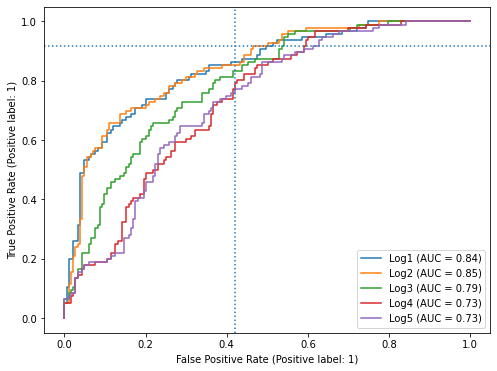

In [18]:
fig, ax = plt.subplots(figsize=(8,6))
log1_disp = RocCurveDisplay.from_estimator(log1, X_tuning, y_tuning, ax=ax, name = "Log1")
log2_disp = RocCurveDisplay.from_estimator(log2, X_tuning, y_tuning, ax=ax, name = "Log2")
log3_disp = RocCurveDisplay.from_estimator(log3, X_tuning, y_tuning, ax=ax, name = "Log3")
log4_disp = RocCurveDisplay.from_estimator(log4, X_tuning, y_tuning, ax=ax, name = "Log4")
log5_disp = RocCurveDisplay.from_estimator(log5, X_tuning, y_tuning, ax=ax, name = "Log5")
ax.axhline(leos[0],linestyle = ":")
ax.axvline(leos[1],linestyle = ":")
plt.show()

In [23]:
log6 = LogisticRegression(solver = "saga", C = 1, max_iter = 10000, tol = 10 ** (-5), penalty = "l1")
log6 = log6.fit(X,y)

VI_df['log_c1_max_iter_10000_l1dini'] = abs(log6.coef_).argsort().argsort()[0]

perm1 = permutation_importance(log6, X, y, n_repeats = 20, random_state = 1)
VI_df['log_c1_max_iter_10000_l1_perm_train'] = abs(perm1.importances_mean).argsort().argsort()
perm2 = permutation_importance(log6, X_tuning, y_tuning, n_repeats= 20, random_state = 1)
VI_df['log_c1_max_iter_10000_l1_perm_tuning'] = abs(perm2.importances_mean).argsort().argsort()

In [24]:
log7 = LogisticRegression(solver = "saga", C = 0.1, max_iter = 10000, tol = 10 ** (-5), penalty = "l1")
log7 = log7.fit(X,y)

VI_df['log_c0.1_max_iter_10000_l1dini'] = abs(log7.coef_).argsort().argsort()[0]

perm1 = permutation_importance(log7, X, y, n_repeats = 20, random_state = 1)
VI_df['log_c0.1_max_iter_10000_l1_perm_train'] = abs(perm1.importances_mean).argsort().argsort()
perm2 = permutation_importance(log7, X_tuning, y_tuning, n_repeats= 20, random_state = 1)
VI_df['log_c0.1_max_iter_10000_l1_perm_tuning'] = abs(perm2.importances_mean).argsort().argsort()

In [25]:
log8 = LogisticRegression(solver = "saga", C = 0.01, max_iter = 10000, tol = 10 ** (-5), penalty = "l1")
log8 = log8.fit(X,y)

VI_df['log_c0.01_max_iter_10000_l1dini'] = abs(log8.coef_).argsort().argsort()[0]

perm1 = permutation_importance(log8, X, y, n_repeats = 20, random_state = 1)
VI_df['log_c0.01_max_iter_10000_l1_perm_train'] = abs(perm1.importances_mean).argsort().argsort()
perm2 = permutation_importance(log8, X_tuning, y_tuning, n_repeats= 20, random_state = 1)
VI_df['log_c0.01_max_iter_10000_l1_perm_tuning'] = abs(perm2.importances_mean).argsort().argsort()

In [26]:
log9 = LogisticRegression(solver = "saga", C = 0.001, max_iter = 10000, tol = 10 ** (-5), penalty = "l1")
log9 = log9.fit(X,y)

VI_df['log_c0.001_max_iter_10000_l1dini'] = abs(log9.coef_).argsort().argsort()[0]

perm1 = permutation_importance(log9, X, y, n_repeats = 20, random_state = 1)
VI_df['log_c0.001_max_iter_10000_l1_perm_train'] = abs(perm1.importances_mean).argsort().argsort()
perm2 = permutation_importance(log9, X_tuning, y_tuning, n_repeats= 20, random_state = 1)
VI_df['log_c0.001_max_iter_10000_l1_perm_tuning'] = abs(perm2.importances_mean).argsort().argsort()

In [27]:
log10 = LogisticRegression(solver = "saga", C = 0.0001, max_iter = 10000, tol = 10 ** (-5), penalty = "l1")
log10 = log10.fit(X,y)

VI_df['log_c0.0001_max_iter_10000_l1dini'] = abs(log10.coef_).argsort().argsort()[0]

perm1 = permutation_importance(log10, X, y, n_repeats = 20, random_state = 1)
VI_df['log_c0.0001_max_iter_10000_l1_perm_train'] = abs(perm1.importances_mean).argsort().argsort()
perm2 = permutation_importance(log10, X_tuning, y_tuning, n_repeats= 20, random_state = 1)
VI_df['log_c0.0001_max_iter_10000_l1_perm_tuning'] = abs(perm2.importances_mean).argsort().argsort()

In [ ]:
# log11 = LogisticRegression(solver = "saga", C = 0.1, max_iter = 10000, tol = 10 ** (-5), penalty = "l1")
# log11 = log11.fit(X,y)

# VI_df['log_c0.15_max_iter_10000_l1dini'] = abs(log11.coef_).argsort().argsort()[0]

# perm1 = permutation_importance(log11, X, y, n_repeats = 20, random_state = 1)
# VI_df['log_c0.15_max_iter_10000_l1_perm_train'] = abs(perm1.importances_mean).argsort().argsort()
# perm2 = permutation_importance(log11, X_tuning, y_tuning, n_repeats= 20, random_state = 1)
# VI_df['log_c0.15_max_iter_10000_l1_perm_tuning'] = abs(perm2.importances_mean).argsort().argsort()

In [ ]:
#log11.coef_

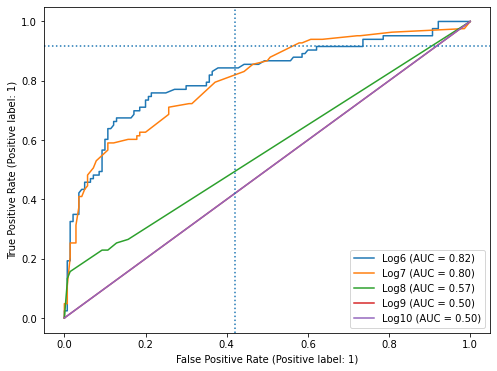

In [28]:
fig, ax = plt.subplots(figsize=(8,6))
log6_disp = RocCurveDisplay.from_estimator(log6, X_tuning, y_tuning, ax=ax, name = "Log6")
log7_disp = RocCurveDisplay.from_estimator(log7, X_tuning, y_tuning, ax=ax, name = "Log7")
log8_disp = RocCurveDisplay.from_estimator(log8, X_tuning, y_tuning, ax=ax, name = "Log8")
log9_disp = RocCurveDisplay.from_estimator(log9, X_tuning, y_tuning, ax=ax, name = "Log9")
log10_disp = RocCurveDisplay.from_estimator(log10, X_tuning, y_tuning, ax=ax, name = "Log10")
ax.axhline(leos[0],linestyle = ":")
ax.axvline(leos[1],linestyle = ":")
plt.show()

In [29]:
log11 = LogisticRegression(solver = "saga", C = 1, max_iter = 10000, tol = 10 ** (-5), penalty = "elasticnet", l1_ratio = 0.25)
log11 = log11.fit(X,y)

VI_df['log_c1_max_iter_10000_elastic_r0.25_dini'] = abs(log11.coef_).argsort().argsort()[0]

perm1 = permutation_importance(log11, X, y, n_repeats = 20, random_state = 1)
VI_df['log_c1_max_iter_10000_elastic_r0.25_perm_train'] = abs(perm1.importances_mean).argsort().argsort()
perm2 = permutation_importance(log11, X_tuning, y_tuning, n_repeats= 20, random_state = 1)
VI_df['log_c1_max_iter_10000_elastic_r0.25_perm_tuning'] = abs(perm2.importances_mean).argsort().argsort()

In [30]:
log12 = LogisticRegression(solver = "saga", C = 1, max_iter = 10000, tol = 10 ** (-5), penalty = "elasticnet", l1_ratio = 0.50)
log12 = log12.fit(X,y)

VI_df['log_c1_max_iter_10000_elastic_r0.50_dini'] = abs(log12.coef_).argsort().argsort()[0]

perm1 = permutation_importance(log12, X, y, n_repeats = 20, random_state = 1)
VI_df['log_c1_max_iter_10000_elastic_r0.50_perm_train'] = abs(perm1.importances_mean).argsort().argsort()
perm2 = permutation_importance(log12, X_tuning, y_tuning, n_repeats= 20, random_state = 1)
VI_df['log_c1_max_iter_10000_elastic_r0.50_perm_tuning'] = abs(perm2.importances_mean).argsort().argsort()

In [31]:
log13 = LogisticRegression(solver = "saga", C = 1, max_iter = 10000, tol = 10 ** (-5), penalty = "elasticnet", l1_ratio = 0.75)
log13 = log13.fit(X,y)

VI_df['log_c1_max_iter_10000_elastic_r0.75_dini'] = abs(log13.coef_).argsort().argsort()[0]

perm1 = permutation_importance(log13, X, y, n_repeats = 20, random_state = 1)
VI_df['log_c1_max_iter_10000_elastic_r0.75_perm_train'] = abs(perm1.importances_mean).argsort().argsort()
perm2 = permutation_importance(log13, X_tuning, y_tuning, n_repeats= 20, random_state = 1)
VI_df['log_c1_max_iter_10000_elastic_r0.75_perm_tuning'] = abs(perm2.importances_mean).argsort().argsort()

In [32]:
log14 = LogisticRegression(solver = "saga", C = 0.1, max_iter = 10000, tol = 10 ** (-5), penalty = "elasticnet", l1_ratio = 0.25)
log14 = log14.fit(X,y)

VI_df['log_c0.1_max_iter_10000_elastic_r0.25_dini'] = abs(log14.coef_).argsort().argsort()[0]

perm1 = permutation_importance(log14, X, y, n_repeats = 20, random_state = 1)
VI_df['log_c0.1_max_iter_10000_elastic_r0.25_perm_train'] = abs(perm1.importances_mean).argsort().argsort()
perm2 = permutation_importance(log14, X_tuning, y_tuning, n_repeats= 20, random_state = 1)
VI_df['log_c0.1_max_iter_10000_elastic_r0.25_perm_tuning'] = abs(perm2.importances_mean).argsort().argsort()

In [33]:
log15 = LogisticRegression(solver = "saga", C = 0.1, max_iter = 10000, tol = 10 ** (-5), penalty = "elasticnet", l1_ratio = 0.50)
log15 = log15.fit(X,y)

VI_df['log_c0.1_max_iter_10000_elastic_r0.50_dini'] = abs(log15.coef_).argsort().argsort()[0]

perm1 = permutation_importance(log15, X, y, n_repeats = 20, random_state = 1)
VI_df['log_c0.1_max_iter_10000_elastic_r0.50_perm_train'] = abs(perm1.importances_mean).argsort().argsort()
perm2 = permutation_importance(log15, X_tuning, y_tuning, n_repeats= 20, random_state = 1)
VI_df['log_c0.1_max_iter_10000_elastic_r0.50_perm_tuning'] = abs(perm2.importances_mean).argsort().argsort()

In [52]:
log16 = LogisticRegression(solver = "saga", C = 0.1, max_iter = 10000, tol = 10 ** (-5), penalty = "elasticnet", l1_ratio = 0.75)
log16 = log16.fit(X,y)

VI_df['log_c0.1_max_iter_10000_elastic_r0.75_dini'] = abs(log16.coef_).argsort().argsort()[0]

perm1 = permutation_importance(log16, X, y, n_repeats = 20, random_state = 1)
VI_df['log_c0.1_max_iter_10000_elastic_r0.75_perm_train'] = (perm1.importances_mean).argsort().argsort()
perm2 = permutation_importance(log16, X_tuning, y_tuning, n_repeats= 20, random_state = 1)
VI_df['log_c0.1_max_iter_10000_elastic_r0.75_perm_tuning'] = (perm2.importances_mean).argsort().argsort()

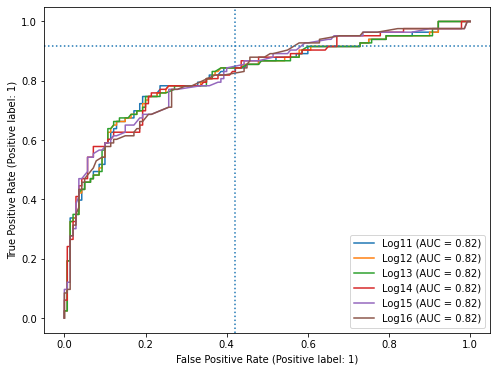

In [44]:
fig, ax = plt.subplots(figsize=(8,6))
log11_disp = RocCurveDisplay.from_estimator(log11, X_tuning, y_tuning, ax=ax, name = "Log11")
log12_disp = RocCurveDisplay.from_estimator(log12, X_tuning, y_tuning, ax=ax, name = "Log12")
log13_disp = RocCurveDisplay.from_estimator(log13, X_tuning, y_tuning, ax=ax, name = "Log13")
log14_disp = RocCurveDisplay.from_estimator(log14, X_tuning, y_tuning, ax=ax, name = "Log14")
log15_disp = RocCurveDisplay.from_estimator(log15, X_tuning, y_tuning, ax=ax, name = "Log15")
log16_disp = RocCurveDisplay.from_estimator(log16, X_tuning, y_tuning, ax=ax, name = "Log16")
ax.axhline(leos[0],linestyle = ":")
ax.axvline(leos[1],linestyle = ":")
plt.show()

In [51]:
temp = VI_df.sort_values('log_c0.1_max_iter_10000_elastic_r0.75_dini')
temp[["name", "if_Leo", 'log_c0.1_max_iter_10000_elastic_r0.75_dini']].head(50)

,name,if_Leo,log_c0.1_max_iter_10000_elastic_r0.75_dini
0,AlteredMentalStatus,1,0
35,TendernessAgg,0,1
34,SubInj,0,2
31,AbnormalMedicalHistory,0,3
28,NonVerbal,0,4
27,VeryYoung,0,5
26,MRIPerformed_outside,0,6
23,helmet,0,7
22,PtCompPainNeckMove,0,8
21,ArrPtIntub,0,9


In [37]:
from sklearn.metrics import recall_score

In [38]:
recall_score(y_tuning, log16.predict(X_tuning))

0.4578313253012048

In [39]:
recall_score(y_tuning, log15.predict(X_tuning))

0.4457831325301205

In [40]:
temp = VI_df.sort_values('log_c0.1_max_iter_10000_elastic_r0.50_perm_tuning')
temp[["name", "if_Leo", 'log_c0.1_max_iter_10000_elastic_r0.50_perm_tuning']].head(10)

,name,if_Leo,log_c0.1_max_iter_10000_elastic_r0.50_perm_tuning
0,AlteredMentalStatus,1,0
35,TendernessAgg,0,1
34,SubInj,0,2
31,AbnormalMedicalHistory,0,3
28,NonVerbal,0,4
27,VeryYoung,0,5
26,MRIPerformed_outside,0,6
22,PtCompPainNeckMove,0,7
21,ArrPtIntub,0,8
20,PtAmbulatoryPriorArrival,0,9


In [ ]:
len(log16.coef_[0])

In [ ]:
X